- Thành Viên Nhóm:
1. Trương Văn Khải - 21520274
2. Đoàn Nhật Sang - 21522542
3. Đặng Phước Sang - 21521377

# **Sarcasm Detection**

1. Mô tả bài toán: Input: 1 headline của 1 bài báo Output: headline châm biếm hoặc không châm biếm
2. Cách thu thập dữ liệu của nhóm: Thu thập các headlines từ 2 trang web: nhandan.vn (chính thống) và cuoi.tuoitre.vn (châm biếm).
  * nhandan.vn: trang báo chuyên về các tin tức chính thống
  * cuoi.tuoitre.vn: trang báo chuyên về các tin châm biếm
3. Dữ liệu train, test
* Training Dataset: sử dụng data tự tổng hợp từ tất cả các nhóm trong lớp
  * Dataset: gồm 2 feature chính
      * headline: tiêu đề bài báo
      * is_sacastic: 1: châm biếm và 0: không châm biếm
* Testing Dataset: sử dụng data tự tổng hợp từ tất cả các nhóm trong lớp


In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 73.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 88.7 MB/s eta 0:00:00


# **Import các thư viện cần thiết**

In [ ]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, logging

import warnings
warnings.filterwarnings("ignore")

logging.set_verbosity_error()

# **Lấy dataset trên github các nhóm**

In [ ]:
import json
import requests
import matplotlib.pyplot as plt

datalist = [
    'https://raw.githubusercontent.com/uyenbhku/CS114.N21/main/sarcasm_detection_dataset/NSFW.json',
    'https://raw.githubusercontent.com/ngcthc/CS114-ML-Public/main/sarcasm_detection_dataset.json',
    'https://raw.githubusercontent.com/Kuma221203/CS114/main/sarcasm_detection_dataset.json',
    'https://raw.githubusercontent.com/dnsang1611/CS114.N21-KHNT/master/sarcasm_detection_dataset.json',
    'https://raw.githubusercontent.com/tqnghia210/CS114/main/data_ne.json',
    'https://raw.githubusercontent.com/Quan-Minh/CS114/main/sarcasm_detection_dataset.json',
    'https://raw.githubusercontent.com/npk7264/CS114/main/sarcasm_detection_dataset.json',
    'https://raw.githubusercontent.com/Tlon9/CS114/main/sarcasm_detection_dataset.json',
    'https://raw.githubusercontent.com/TruongNoDame/Sarcasm-Detection/main/sarcasm_detection_dataset.json',
    'https://raw.githubusercontent.com/HungStark/sarcasm_detection_dataset/main/sarcasm_detection_dataset.json',
    'https://raw.githubusercontent.com/KiRzEa/CS114/main/SarcasmData/SarcasmData.json',
    'https://raw.githubusercontent.com/phongidoit/CS114/main/sarcasm_detection_dataset.json'
]

dataset = pd.DataFrame(columns = ['headline', 'article_link', 'is_sarcastic'])

# print(dataset)
for url in datalist:
  try:
    resp = requests.get(url)
    data = json.loads(resp.text)
    df = pd.json_normalize(data)
    df = df.rename(columns={'title':'headline', 'is_sarcasm': 'is_sarcastic'})
    dataset = pd.concat([dataset, df], axis=0)
    # print(url +' length: '+  str(len(data)))
  except:
    print(url)
    resp = requests.get(url)
    if url in ['https://raw.githubusercontent.com/Tlon9/CS114/main/sarcasm_detection_dataset.json', 'https://raw.githubusercontent.com/uyenbhku/CS114.N21/main/sarcasm_detection_dataset/NSFW.json', 'https://raw.githubusercontent.com/Quan-Minh/CS114/main/sarcasm_detection_dataset.json']:
      data = '['
      for sample in resp.text.split('\n'):
        sample = sample.strip()
        if sample != '':
          data += sample + ','
      data = data[:-1] + ']'
    else:
      data = '[' + resp.text + ']'
    data = json.loads(data)
    df = pd.json_normalize(data)
    df = df.rename(columns={'title':'headline', 'is_sarcasm': 'is_sarcastic'})
    dataset = pd.concat([dataset, df], axis=0)

dataset.info()

https://raw.githubusercontent.com/uyenbhku/CS114.N21/main/sarcasm_detection_dataset/NSFW.json
https://raw.githubusercontent.com/tqnghia210/CS114/main/data_ne.json
https://raw.githubusercontent.com/Quan-Minh/CS114/main/sarcasm_detection_dataset.json
https://raw.githubusercontent.com/Tlon9/CS114/main/sarcasm_detection_dataset.json
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10143 entries, 0 to 454
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   headline      10143 non-null  object
 1   article_link  6683 non-null   object
 2   is_sarcastic  10143 non-null  object
dtypes: object(3)
memory usage: 317.0+ KB


In [ ]:
# Bỏ cột article_link
dataset = dataset.drop(['article_link'], axis=1)

# Lọc bỏ các sample trùng
dataset = dataset.drop_duplicates()

dataset.reset_index(inplace=True)
dataset.drop('index', axis=1, inplace=True)
dataset.is_sarcastic = dataset.is_sarcastic.astype(np.int32)

Word segment cho headline

In [ ]:
!pip install py_vncorenlp

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 39.8 MB/s eta 0:00:00
  Created wheel for py_vncorenlp: filename=py_vncorenlp-0.1.4-py3-none-any.whl size=4305 sha256=e47945f3ba2a7f804a57282559ee405e0e73a25d88378c3331179828e916e55d
  Stored in directory: /root/.cache/pip/wheels/d5/d9/bf/62632cdb007c702a0664091e92a0bb1f18a2fcecbe962d9827
Successfully built py_vncorenlp


In [ ]:
import py_vncorenlp

# Automatically download VnCoreNLP components from the original repository
# and save them in some local machine folder
py_vncorenlp.download_model(save_dir='./')

# Load the word and sentence segmentation component
rdrsegmenter = py_vncorenlp.VnCoreNLP(annotators=["wseg"], save_dir='./')
# ['Ông Nguyễn_Khắc_Chúc đang làm_việc tại Đại_học Quốc_gia Hà_Nội .', 'Bà Lan , vợ ông Chúc , cũng làm_việc tại đây .']

text = "Ông Nguyễn Khắc Chúc  đang làm việc tại Đại học Quốc gia Hà Nội. Bà Lan, vợ ông Chúc, cũng làm việc tại đây."

output = rdrsegmenter.word_segment(text)

print(output)

['Ông Nguyễn_Khắc_Chúc đang làm_việc tại Đại_học Quốc_gia Hà_Nội .', 'Bà Lan , vợ ông Chúc , cũng làm_việc tại đây .']


In [ ]:
# Word segmentation cho dataset
failed_indices = []
for i in range(dataset.shape[0]):
  text  = dataset.iloc[i]['headline'].strip()
  # Kiểm tra xem headline có phải rỗng không?
  if text != '':
      dataset.at[i, 'headline'] = ''.join(rdrsegmenter.word_segment(text))
  else:
    failed_indices.append(dataset.iloc[i].name)

# Bỏ những sample có trường headline trống.
if (failed_indices):
  print(failed_indices)
  dataset = dataset.drop(failed_indices, axis=0)

[424, 466]


## **EDA**

In [ ]:
dataset.info()
dataset.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9208 entries, 0 to 9209
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   headline      9208 non-null   object
 1   is_sarcastic  9208 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 179.8+ KB


,headline,is_sarcastic
0,Nhà Chuột bị chê phá nát tuổi_thơ của bao thế_hệ,1
1,Đến lượt công_chúa tóc_mây Disney có bản người...,1
2,Chế_giễu ngoại_hình từ câu_chuyện về nàng tiên...,1
3,Lãnh_Thanh bị chê diễn đơ trong Nơi Giấc_Mơ_Tì...,1
4,Nhân_vật vô_lý nhất phim Cuộc_Đời Vẫn Đẹp_Sao,1


Dataset của mỗi nhóm sẽ có 2 hoặc 3 trường thông tin, gọi chung là headline, is_sarcastic, article_link. Vì nhóm không sử dụng trường article_link cho train model nên sẽ bỏ nó ra khỏi dataset.

Sau khi lấy data về, tổng số sample là 10143 ==> Tiến hành lọc bỏ các sample trùng và các sample có trường headline rỗng.

Tiến hành segment word trên dataset.

Qua một vài bước xử lý nêu trên, dataset còn:
* 2 cột: headline, is_sarcastic (0: không châm biếm, 1: châm biếm).
* Số sample sau khi lọc trùng và các sample có headline rỗng là 9208.

# **Phân chia tập dữ liệu cho train-val-test theo tỷ lệ 7:1:2**

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(dataset, test_size=0.3)
valid_df, test_df = train_test_split(test_df, test_size=0.66)

=== train histogram ===
label  #
0    3924
1    2521
Name: is_sarcastic, dtype: int64


array([[<Axes: title={'center': 'is_sarcastic'}>]], dtype=object)

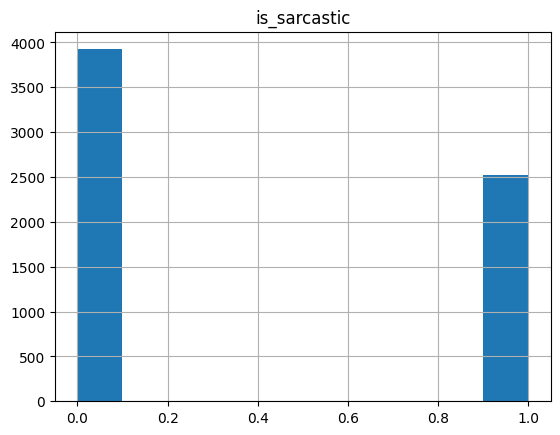

In [ ]:
print('=== train histogram ===')
print('label  #')
print(train_df.is_sarcastic.value_counts())
train_df.hist()

=== val histogram ===
label  #
0    569
1    370
Name: is_sarcastic, dtype: int64


array([[<Axes: title={'center': 'is_sarcastic'}>]], dtype=object)

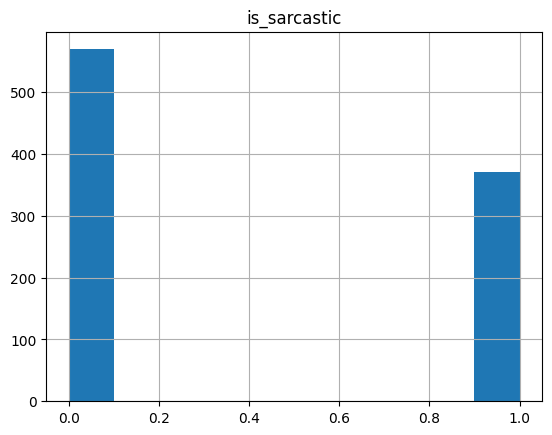

In [ ]:
print('=== val histogram ===')
print('label  #')
print(valid_df.is_sarcastic.value_counts())
valid_df.hist()

=== test histogram ===
label  #
0    1124
1     700
Name: is_sarcastic, dtype: int64


array([[<Axes: title={'center': 'is_sarcastic'}>]], dtype=object)

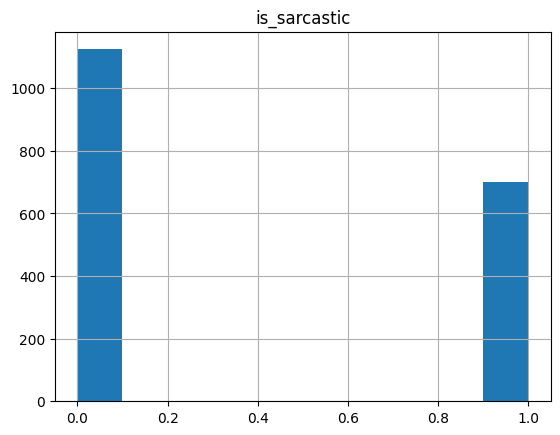

In [ ]:
print('=== test histogram ===')
print('label  #')
print(test_df.is_sarcastic.value_counts())
test_df.hist()

# **I. Traning model: vinai/phobert-base**
1. Segment word cho câu với vncorenlp
2. Chỉnh chử hoa trong headline thành chữ thường.
3. Dùng pretrained tokenizer ứng với phobert-base. Tokenizer sẽ segment câu thành các đơn vị subword, sử dụng từ điển có 64K subword types (Nguồn: https://aclanthology.org/2020.findings-emnlp.92.pdf). Sau đó chuyển text dưới dạng các subwords về dạng index trong từ điển và thực hiện một số thao tác khác được nêu cụ thể ở phần SentimentDataset.
4. Sử dụng PhoBERT-base để chuyển mảng index này thành mảng các số đại diện cho câu.
5. Sử dụng một fully connected layer để đưa ra dự đoán là 0 hoặc 1

K Fold Cross Validation <a id ="3"></a>

Trong phương pháp K-fold cross-validation, dữ liệu đầu vào được chia thành 'K' tập con, do đó được gọi là K-Fold. Giả sử chúng ta chia dữ liệu thành 5 tập con, tức K=5. Lúc này, chúng ta có 5 tập dữ liệu để huấn luyện và kiểm thử mô hình. Vì vậy, mô hình sẽ được huấn luyện và kiểm thử 5 lần, trong mỗi lần chúng ta sẽ sử dụng một tập con làm dữ liệu kiểm thử và các tập con còn lại làm dữ liệu huấn luyện. Ví dụ, cho mỗi lần lặp, dữ liệu trong các tập con huấn luyện và kiểm thử sẽ thay đổi, điều này làm tăng tính hiệu quả của phương pháp này.

![KFold_Cross_Validation](https://raw.githubusercontent.com/satishgunjal/images/master/KFold_Cross_Validation.png)

Cấu hình thiết bị và cài đặt:

*   vòng lặp huấn luyện (epochs): 6
*   phân chia (splits) dữ liệu: 3


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
EPOCHS = 6
N_SPLITS = 3

In [ ]:
# We will use Kfold later
temp_train_df = train_df.copy()
train_df = pd.concat([train_df, valid_df], ignore_index=True)
skf = StratifiedKFold(n_splits=N_SPLITS)
for fold, (_, val_) in enumerate(skf.split(X=train_df, y=train_df.is_sarcastic)):
    train_df.loc[val_, "kfold"] = fold

In [ ]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=120):
        self.df = df
        self.max_len = max_len
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]

        text = row['headline']
        text = ' '.join(simple_preprocess(text)) # lower sentence

        label = row['is_sarcastic']

        # Encode_plus will:
        # (1) split text into token
        # (2) Add the '[CLS]' and '[SEP]' token to the start and end
        # (3) Truncate/Pad sentence to max length
        # (4) Map token to their IDS
        # (5) Create attention mask
        # (6) Return a dictionary of outputs
        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_masks': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long),
        }

        return text, label

Text(0.5, 9.444444444444438, 'Token Count')

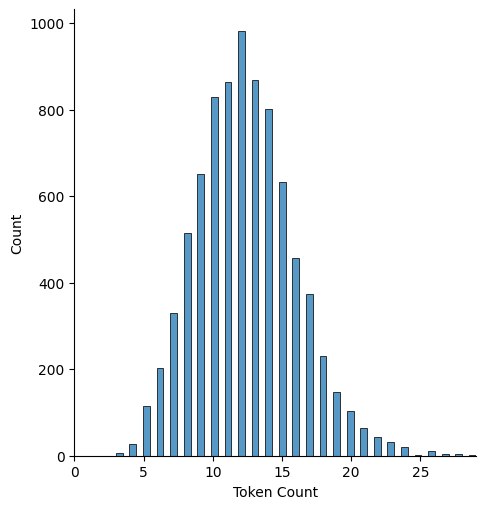

In [ ]:
# Distribution of length of Sentence
all_data = train_df.headline.tolist()
all_data = [' '.join(simple_preprocess(text)) for text in all_data]
encoded_text = [tokenizer.encode(text, add_special_tokens=True) for text in all_data]
token_lens = [len(text) for text in encoded_text]
sns.displot(token_lens)
plt.xlim([0,max(token_lens)])
plt.xlabel('Token Count')

**BERT hoạt động với các chuỗi có độ dài cố định. Chúng tôi sẽ sử dụng một chiến lược đơn giản để chọn độ dài có thể phủ được hầu hết các trường hợp trong train là 25.**
=> Dựa vào biểu đồ trên, chọn max_lenght là 25 là 1 phương án tốt

## **1. Auto Model**

In [ ]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes, pretrained= 'vinai/phobert-base'):
        super(SentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(pretrained)
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False # Dropout will errors if without this
        )

        x = self.drop(output)
        x = self.fc(x)
        return x

## 2. Training phase

In [ ]:
def train(model, criterion, optimizer, train_loader):
    model.train()
    losses = []
    correct = 0

    for data in train_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = criterion(outputs, targets)
        _, pred = torch.max(outputs, dim=1)

        correct += torch.sum(pred == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()

    print(f'Train Accuracy: {correct.double()/len(train_loader.dataset)} Loss: {np.mean(losses)}')

def eval(test_data = False):
    model.eval()
    losses = []
    correct = 0

    with torch.no_grad():
        data_loader = test_loader if test_data else valid_loader
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_masks'].to(device)
            targets = data['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, pred = torch.max(outputs, dim=1)

            loss = criterion(outputs, targets)
            correct += torch.sum(pred == targets)
            losses.append(loss.item())

    if test_data:
        print(f'Test Accuracy: {correct.double()/len(test_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(test_loader.dataset)
    else:
        print(f'Valid Accuracy: {correct.double()/len(valid_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(valid_loader.dataset)

In [ ]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)

    train_dataset = SentimentDataset(df_train, tokenizer, max_len=25)
    valid_dataset = SentimentDataset(df_valid, tokenizer, max_len=25)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
    valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True, num_workers=2)

    return train_loader, valid_loader

In [ ]:
for fold in range(skf.n_splits):
    print(f'-----------Fold: {fold+1} ------------------')
    train_loader, valid_loader = prepare_loaders(train_df, fold=fold)
    model = SentimentClassifier(n_classes=2, pretrained='vinai/phobert-base').to(device)
    criterion = nn.CrossEntropyLoss()
    # Recommendation by BERT: lr: 5e-5, 2e-5, 3e-5
    # Batchsize: 16, 32
    optimizer = AdamW(model.parameters(), lr=2e-5)

    lr_scheduler = get_linear_schedule_with_warmup(
                optimizer,
                num_warmup_steps=0,
                num_training_steps=len(train_loader)*EPOCHS
            )
    best_acc = 0
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch+1}/{EPOCHS}')
        print('-'*30)

        train(model, criterion, optimizer, train_loader)
        val_acc = eval()

        if val_acc > best_acc:
            torch.save(model.state_dict(), f'phobert_fold{fold+1}.pth')
            best_acc = val_acc

-----------Fold: 1 ------------------
Epoch 1/6
------------------------------
Train Accuracy: 0.803352559480894 Loss: 0.42149799769094765
Valid Accuracy: 0.8356756756756757 Loss: 0.389943590237834
Epoch 2/6
------------------------------
Train Accuracy: 0.9133020908435472 Loss: 0.23505841405466413
Valid Accuracy: 0.861981981981982 Loss: 0.41700452076399636
Epoch 3/6
------------------------------
Train Accuracy: 0.9549387166546502 Loss: 0.15039645972854918
Valid Accuracy: 0.870990990990991 Loss: 0.5309701361399058
Epoch 4/6
------------------------------
Train Accuracy: 0.9736842105263157 Loss: 0.09630166303858924
Valid Accuracy: 0.8792792792792793 Loss: 0.5915689214390981
Epoch 5/6
------------------------------
Train Accuracy: 0.9841384282624368 Loss: 0.06424091856588506
Valid Accuracy: 0.8839639639639639 Loss: 0.6076105829561129
Epoch 6/6
------------------------------
Train Accuracy: 0.990086517664023 Loss: 0.04223866466102687
Valid Accuracy: 0.8821621621621621 Loss: 0.63261216120

## **3. Testing phase**

In [ ]:
def test(data_loader):
    models = []
    for fold in range(skf.n_splits):
        model = SentimentClassifier(n_classes=2)
        model.to(device)
        model.load_state_dict(torch.load(f'phobert_fold{fold+1}.pth'))
        model.eval()
        models.append(model)

    texts = []
    predicts = []
    predict_probs = []
    real_values = []

    for data in data_loader:
        text = data['text']
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        total_outs = []
        for model in models:
            with torch.no_grad():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                total_outs.append(outputs)

        total_outs = torch.stack(total_outs)
        _, pred = torch.max(total_outs.mean(0), dim=1)
        texts.extend(text)
        predicts.extend(pred)
        predict_probs.extend(total_outs.mean(0))
        real_values.extend(targets)

    predicts = torch.stack(predicts).cpu()
    predict_probs = torch.stack(predict_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    print(classification_report(real_values, predicts))
    return real_values, predicts

In [ ]:
test_dataset = SentimentDataset(test_df, tokenizer, max_len=15)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)
real_values, predicts = test(test_loader)

              precision    recall  f1-score   support

           0       0.90      0.93      0.92      1124
           1       0.88      0.84      0.86       700

    accuracy                           0.89      1824
   macro avg       0.89      0.88      0.89      1824
weighted avg       0.89      0.89      0.89      1824



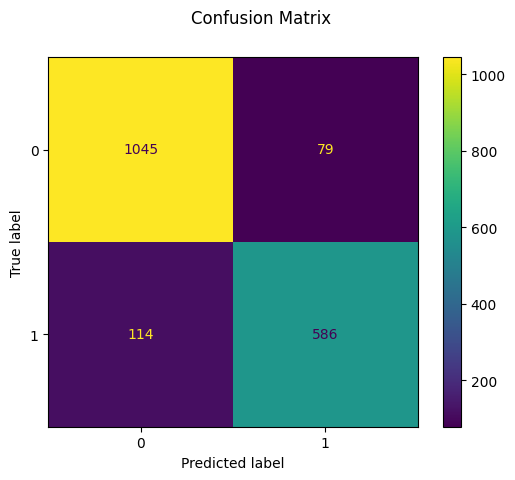

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_predictions(real_values, predicts)
disp.figure_.suptitle("Confusion Matrix")
plt.show()

## **4. Find all wrong predictions**

In [ ]:
class_names = ['non sarcasm', 'sarcasm']

def check_wrong(real_values, predicts, df):
    wrong_true_labels= []
    wrong_pred_labels = []
    wrong_txts = []
    for i in range(len(predicts)):
        if predicts[i] != real_values[i]:
            wrong_true_labels.append(real_values[i])
            wrong_pred_labels.append(predicts[i])
            wrong_txts.append(df.iloc[i].headline)
    return wrong_true_labels, wrong_pred_labels, wrong_txts

wrong_true_labels, wrong_pred_labels, wrong_txts = check_wrong(real_values, predicts, test_df)
phobert_wrong_headline = []
print("Number of wrong predict: ", len(wrong_true_labels))
print("The first 50 headlines with wrong predictions:")
for i in range(50):
    print('-'*50)
    phobert_wrong_headline.append(wrong_txts[i])
    print(wrong_txts[i])
    print(f'Predicted: ({class_names[wrong_pred_labels[i]]}) --vs-- Real label: ({class_names[wrong_true_labels[i]]})')

Number of wrong predict:  193
The first 50 headlines with wrong predictions:
--------------------------------------------------
Mekong_Delta_Marathon ' mở_cửa ’ đến World_Marathon_Majors
Predicted: (sarcasm) --vs-- Real label: (non sarcasm)
--------------------------------------------------
Anh lần đầu thử_nghiệm xe_buýt không người lái
Predicted: (non sarcasm) --vs-- Real label: (sarcasm)
--------------------------------------------------
' Sửng_sốt ' vì ô_tô mới mua không có lốp dự_phòng , lý_do là gì ?
Predicted: (sarcasm) --vs-- Real label: (non sarcasm)
--------------------------------------------------
Chủ_tịch ngân_hàng gây sốt sau khi hát ' Cô_đơn trên sofa '
Predicted: (sarcasm) --vs-- Real label: (non sarcasm)
--------------------------------------------------
Đề_xuất tiền gửi ngân_hàng lãi_suất 0% gây sốc
Predicted: (non sarcasm) --vs-- Real label: (sarcasm)
--------------------------------------------------
Sinh_viên có việc_làm cao ngất_ngưởng , nhiều ngành đạt 100%
Predic

**Nhận xét các câu dự đoán sai dự trên phương pháp sử dụng phobert/base**
- Theo nhóm chúng em quan sát, có nhưng câu chính tụi em cũng không biết nó là châm biếm hay không châm biếm, nên việc model dự đoán sai cũng có thể chấp nhận được
  *  Ví dụ: Những biển quảng_cáo sáng_tạo đầy ấn_tượng
Predicted: (non sarcasm) --vs-- Real label: (sarcasm)
  *  Nghe_nói Tết năm nay được nghỉ 9 ngày
Predicted: (non sarcasm) --vs-- Real label: (sarcasm)
- Nhưng bên cạnh đó, cũng có nhưng câu có thể bị label sai, ví dụ như:
  *  Ví dụ: Mắc mệt vì xem những người đẹp cãi_vã kiểu ' thái_độ hơn trình_độ '
Predicted: (sarcasm) --vs-- Real label: (non sarcasm)
  *  Ví dụ: Mất điện , coi_chừng mất luôn ' đại_bàng '
Predicted: (sarcasm) --vs-- Real label: (non sarcasm)
  * Vi du: Nhân_viên ' giãy đành_đạch ' không chịu đi làm quá 4 ngày / tuần
Predicted: (sarcasm) --vs-- Real label: (non sarcasm)

# **II. SVC**
1. Preprocess: Segment word với vncorenlp
2. Pipeline: sử dụng TfidfVectorizer để chuyển đổi dữ liệu văn bản thành ma trận TF-IDF
3. RandomizedSearchCV: để tìm kiếm siêu tham số tốt nhất cho mô hình Support Vector Classifier (SVC) dựa tên X_train và y_train
4. Classifier: SVC

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

In [ ]:
train_df = temp_train_df
X_train, y_train = train_df.headline, train_df.is_sarcastic
X_val, y_val = valid_df.headline, valid_df.is_sarcastic
X_train = np.concatenate((X_train, X_val), axis=0)
y_train = np.concatenate((y_train, y_val), axis=0)
X_test, y_test = test_df.headline, test_df.is_sarcastic

## **1. Training phase**

In [ ]:
# Xây dựng pipeline
pipeline_svc = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', SVC()),
])

param_dist_svc = {
    'tfidf__max_df': (0.5, 0.75, 1.0),
    'tfidf__min_df': (1, 2),
    'tfidf__ngram_range': ((1, 1), (1, 2)),
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__C': np.logspace(-3, 3, 7),
    'clf__gamma': np.logspace(-3, 3,7)
}

# Tìm các hyperparameters tốt trên svc và training data
random_search_svc = RandomizedSearchCV(pipeline_svc,
                                      param_distributions=param_dist_svc,
                                      n_iter=10,
                                      cv=5)

# Train
random_search_svc.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('clf', SVC())]),
                   param_distributions={'clf__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'clf__gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'tfidf__max_df': (0.5, 0.75, 1.0),
                                        'tfidf__min_df': (1, 2),
                                        'tfidf__ngram_range': ((1, 1), (1, 2)),
                                        'tfidf__norm': ('l1', 'l2'),
                                        'tfidf__use_idf': (True, False)})

In [ ]:
# Score trên tập train
random_search_svc.score(X_train, y_train)

0.9983179142136249

## **2. Testing phase**

In [ ]:
random_search_svc.score(X_test, y_test)

0.8645833333333334

In [ ]:
y_pred = random_search_svc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.85      0.89      1124
           1       0.79      0.88      0.83       700

    accuracy                           0.86      1824
   macro avg       0.86      0.87      0.86      1824
weighted avg       0.87      0.86      0.87      1824



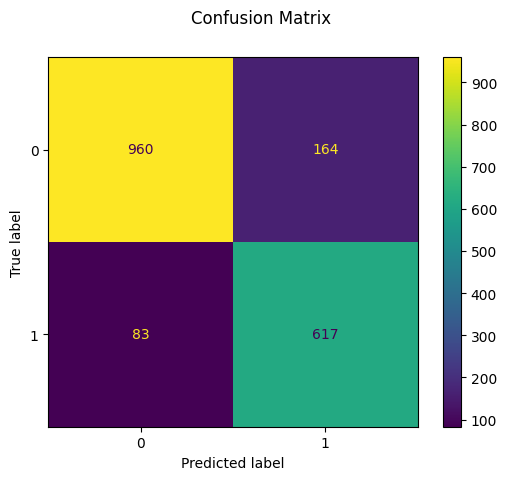

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.figure_.suptitle("Confusion Matrix")
plt.show()

## **3. Find all wrong predictions**

In [ ]:
X_test, y_test = np.array(X_test), np.array(y_test)
class_names = ['non sarcasm', 'sarcasm']
def check_wrong(y_test, y_pred, df):
    wrong_true_labels = []
    wrong_pred_labels = []
    wrong_txts = []
    for i in range(len(y_pred)):
        if y_pred[i] != y_test[i]:
            wrong_true_labels.append(y_test[i])
            wrong_pred_labels.append(y_pred[i])
            wrong_txts.append(df.iloc[i].headline)
    return wrong_true_labels, wrong_pred_labels, wrong_txts

wrong_true_labels, wrong_pred_labels, wrong_txts = check_wrong(y_test, y_pred, test_df)
svm_wrong_headline = []
print("Number of wrong predict: ", len(wrong_true_labels))
print("The first 50 headlines with wrong predictions:")

for i in range(50):
    print('-'*50)
    svm_wrong_headline.append(wrong_txts[i])
    print(wrong_txts[i])
    print(f'Predicted: ({class_names[wrong_pred_labels[i]]}) --vs-- Real label: ({class_names[wrong_true_labels[i]]})')

Number of wrong predict:  247
The first 50 headlines with wrong predictions:
--------------------------------------------------
' Sửng_sốt ' vì ô_tô mới mua không có lốp dự_phòng , lý_do là gì ?
Predicted: (sarcasm) --vs-- Real label: (non sarcasm)
--------------------------------------------------
Đề_xuất tiền gửi ngân_hàng lãi_suất 0% gây sốc
Predicted: (non sarcasm) --vs-- Real label: (sarcasm)
--------------------------------------------------
Singapore biến trường_đua ngựa duy_nhất thành nhà ở xã_hội
Predicted: (sarcasm) --vs-- Real label: (non sarcasm)
--------------------------------------------------
Sinh_viên có việc_làm cao ngất_ngưởng , nhiều ngành đạt 100%
Predicted: (non sarcasm) --vs-- Real label: (sarcasm)
--------------------------------------------------
PV độc_quyền Lucie_Nguyễn - Tuấn_Dương : " Lan_Ngọc sẽ làm dâu phụ , mong Kỳ_Duyên - Minh_Triệu bắt ...
Predicted: (non sarcasm) --vs-- Real label: (sarcasm)
--------------------------------------------------
Tài_xế cô

**Nhận xét các câu dự đoán sai dự trên phương pháp sử dụng SVM**
- Theo nhóm chúng em quan sát, có nhưng câu chính tụi em cũng không biết nó là châm biếm hay không châm biếm, nên việc model dự đoán sai cũng có thể chấp nhận được
  *  Ví dụ:' Sửng_sốt ' vì ô_tô mới mua không có lốp dự_phòng , lý_do là gì ?
Predicted: (sarcasm) --vs-- Real label: (non sarcasm)
  *  Tiền học thêm gấp đôi học_phí : Khoản nào tiền đúng , khoản gì tiền sai ?
Predicted: (non sarcasm) --vs-- Real label: (sarcasm)
- Nhưng bên cạnh đó, cũng có nhưng câu có thể bị label sai, ví dụ như:
  *  Ví dụ: Nhân_viên ' giãy đành_đạch ' không chịu đi làm quá 4 ngày / tuần
Predicted: (sarcasm) --vs-- Real label: (non sarcasm)


# **III. Logistic regression**
1. Preprocess: Segment word với vncorenlp
2. Pipeline: sử dụng TfidfVectorizer để chuyển đổi dữ liệu văn bản thành ma trận TF-IDF
3. Classifier: Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

## **1. Training phase**

In [ ]:
from scipy.stats import loguniform

# Xây dựng pipeline
pipeline_log_reg = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression()),
])

# Train
pipeline_log_reg.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LogisticRegression())])

In [ ]:
# Score trên tập train
pipeline_log_reg.score(X_train, y_train)

0.9319956746365493

## **2. Testing phase**

In [ ]:
pipeline_log_reg.score(X_test, y_test)

0.8229166666666666

In [ ]:
y_pred = pipeline_log_reg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1124
           1       0.81      0.70      0.75       700

    accuracy                           0.82      1824
   macro avg       0.82      0.80      0.81      1824
weighted avg       0.82      0.82      0.82      1824



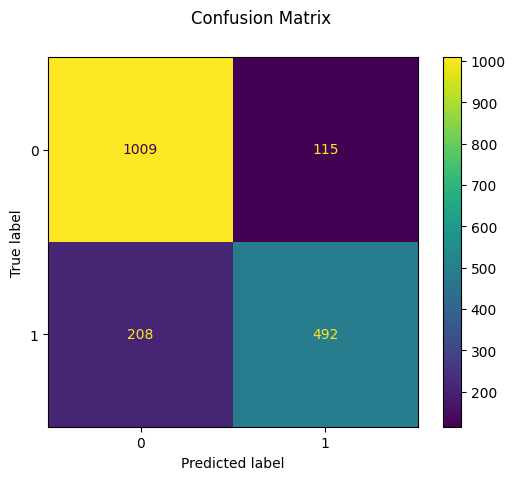

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.figure_.suptitle("Confusion Matrix")
plt.show()

## **3. Find wrong predictions**

In [ ]:
X_test, y_test = np.array(X_test), np.array(y_test)
class_names = ['non sarcasm', 'sarcasm']
def check_wrong(y_test, y_pred, df):
    wrong_true_labels = []
    wrong_pred_labels = []
    wrong_txts = []
    for i in range(len(y_pred)):
        if y_pred[i] != y_test[i]:
            wrong_true_labels.append(y_test[i])
            wrong_pred_labels.append(y_pred[i])
            wrong_txts.append(df.iloc[i].headline)
    return wrong_true_labels, wrong_pred_labels, wrong_txts

wrong_true_labels, wrong_pred_labels, wrong_txts = check_wrong(y_test, y_pred, test_df)
svm_wrong_headline = []
print("Number of wrong predict: ", len(wrong_true_labels))
print("The first 50 headlines with wrong predictions:")

for i in range(50):
    print('-'*50)
    svm_wrong_headline.append(wrong_txts[i])
    print(wrong_txts[i])
    print(f'Predicted: ({class_names[wrong_pred_labels[i]]}) --vs-- Real label: ({class_names[wrong_true_labels[i]]})')

Number of wrong predict:  323
The first 50 headlines with wrong predictions:
--------------------------------------------------
Tiệc cưới xu_hướng mới
Predicted: (non sarcasm) --vs-- Real label: (sarcasm)
--------------------------------------------------
Người thu_nhập thấp méo_mặt với định_luật vạn_vật hấp_dẫn
Predicted: (non sarcasm) --vs-- Real label: (sarcasm)
--------------------------------------------------
Anh lần đầu thử_nghiệm xe_buýt không người lái
Predicted: (non sarcasm) --vs-- Real label: (sarcasm)
--------------------------------------------------
' Sửng_sốt ' vì ô_tô mới mua không có lốp dự_phòng , lý_do là gì ?
Predicted: (sarcasm) --vs-- Real label: (non sarcasm)
--------------------------------------------------
Đề_xuất tiền gửi ngân_hàng lãi_suất 0% gây sốc
Predicted: (non sarcasm) --vs-- Real label: (sarcasm)
--------------------------------------------------
Singapore biến trường_đua ngựa duy_nhất thành nhà ở xã_hội
Predicted: (sarcasm) --vs-- Real label: (non s

**Nhận xét các câu dự đoán sai dự trên phương pháp sử dụng Logistic Regression**
- Theo nhóm chúng em quan sát, có nhưng câu chính tụi em cũng không biết nó là châm biếm hay không châm biếm, nên việc model dự đoán sai cũng có thể chấp nhận được
  *  Ví dụ: Thanh_niên tăng cả trăm ký sau khi làm clip mukbang
Predicted: (non sarcasm) --vs-- Real label: (sarcasm)
=> Predicted: (non sarcasm) --vs-- Real label: (sarcasm)
  *  Ví dụ: ' Sửng_sốt ' vì ô_tô mới mua không có lốp dự_phòng , lý_do là gì ?
Predicted: (sarcasm) --vs-- Real label: (non sarcasm)
- Nhưng bên cạnh đó, cũng có nhưng câu có thể bị label sai, ví dụ như:
  *  Ví dụ: Anh lần đầu thử_nghiệm xe_buýt không người lái
Predicted: (non sarcasm) --vs-- Real label: (sarcasm)
=> Predicted: (non sarcasm) --vs-- Real label: (sarcasm)
  *  Ví dụ: Nhân_viên ' giãy đành_đạch ' không chịu đi làm quá 4 ngày / tuần
Predicted: (sarcasm) --vs-- Real label: (non sarcasm)


# **Nhận Xét**
- Cả 3 phương pháp đều dự đoán trên bộ test
- Ở phương pháp sử dụng: Phobert-base với AutoModel (Tổng là 1824 câu test)
  *  Tập dựa đoán sai là 193 câu
- Ở phương pháp sử dụng: Logistic Regression (Tổng là 1824 câu test)
  *  Tập dựa đoán sai là 323 câu
- Ở phương pháp sử dụng: Pipeline, RandomizedSearchCV và SVM (Tổng là 1824 câu test)
  *  Tập dựa đoán sai là 247 câu
- Performance Metric:
  *  Sử dụng Phobert-base với AutoModel: Accuracy ~ 89%; ; Precision ~ 88%; Recall ~ 89%
  *  Sử dụng Pipeline, RandomizedSearchCV và SVC: Accuracy ~ 86%; Precision ~ 86%; Recall ~ 87%
  *  Sử dụng Logistic Regression: Accuracy ~ 82%; ; Precision ~ 82%; Recall ~ 80%
  
  (Lưu ý: Em chỉ sử dụng Precision với Recall trong marco)

==> Trong 3 model trên thì PhoBERT-base có accuracy, macro, weighted f1-score tốt nhất (0.89) và vì các evaluation metric đều xấp xỉ 0.9 nên PhoBERT này hoạt động tốt.

